In [23]:
import xarray as xr
import aostools as aos
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# import dataset
ds = xr.open_mfdataset('/home/links/ct715/reanalysis_data/eddy_feedback/daily_datasets/jra55_djb_ep.nc')

# NH subset
ds = ds.isel(lat=slice(0, 37))
ds

<xarray.Dataset>
Dimensions:  (time: 5325, lon: 144, lat: 37, level: 37)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01T09:00:00 ... 2016-12-31T09:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... 10.0 7.5 5.0 2.5 0.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    v        (time, level, lat, lon) float32 dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    u        (time, level, lat, lon) float32 dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    ep1      (time, level, lat) float64 dask.array<chunksize=(1, 37, 37), meta=np.ndarray>
    ep2      (time, level, lat) float64 dask.array<chunksize=(1, 37, 37), meta=np.ndarray>
    div1     (time, level, lat) float64 dask.array<chunksize=(1, 37, 37), meta=np.ndarray>
    div2     (time, level, lat) float64 dask.array<chunksize=(1, 37, 37), meta=np.ndarray>
    ubar     (level, lat) float32 dask.array<chunksize=(37, 37), meta=np.ndarray>

We want interannual time series of reanalysis data.

In [25]:
ubar = ds.u.mean(('lon'))
div1 = ds.div1
div2 = ds.div2

# separate time into annual means
ubar = ubar.groupby('time.year').mean('time').load()
div1 = div1.groupby('time.year').mean('time').load()
div2 = div2.groupby('time.year').mean('time').load()

print(len(ubar[0,0,:]))
ubar.shape

37


(59, 37, 37)

In [26]:
# define function
def correlation_array(da1, da2):
    
    """
    Input: two Xarray DataArrays of same shape (time,level,lat)
    
    Output: a NumPy array of correlation coefficients,
            of shape (level, lat)
    """
    
    # show progress bar
    from tqdm import tqdm
    
    # create array of desired shape
    da_corr = np.zeros((len(da1[0,:,0]), len(da1[0,0,:])))
    
    # loop through each variable
    # on each row, do each column entry
    for i in tqdm(range(len(da1[0,:,0]))):
        for j in range(len(da1[0,0,:])):
            
            # calculate correlation coefficient
            corr = np.corrcoef(da1[:,i, j], da2[:,i, j])
            
            # save coefficient to respective data point
            da_corr[i, j] = corr[0,1]
            
    return da_corr 

In [27]:
corr = correlation_array(ubar, div1)

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 64.33it/s]


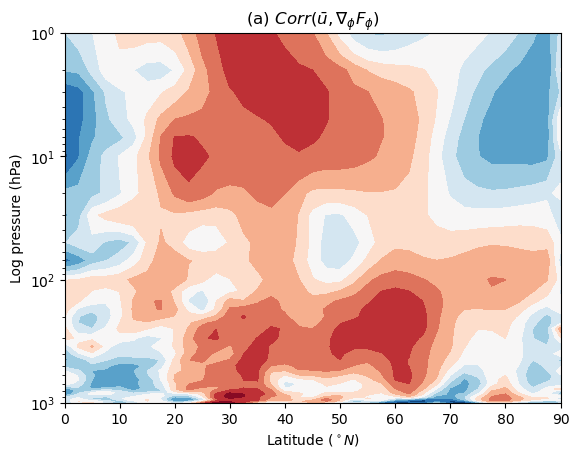

In [32]:
plt.figure()
plt.contourf(ds.lat.values, ds.level.values, corr, cmap='RdBu_r', levels=10)
plt.yscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Latitude $(^\\circ N)$')
plt.ylabel('Log pressure (hPa)')
plt.title('(a) $Corr(\\bar{u}, \\nabla_{\\phi} F_{\\phi})$')
plt.show()